# Convolutional neural network 

Prepared by Nicolas Desassis from [Pytorch documentation](https://https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
)


## Imports and data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In this notebook, we will work with the [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


<div>
<img src="https://pytorch.org/tutorials/_images/cifar10.png" width="500"/>
</div>



Tensorflow proposes many data-sets that are ready to use, including CIFAR 10 :

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170508288/170498071 [==============================] - 14s 0us/step


Plot some example images

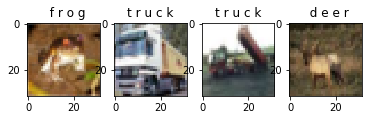

In [3]:
for i in range(4):
  plt.subplot(1, 4, i+1)
  # show images
  plt.imshow(x_train[i])
  # print labels
  plt.title(' '.join('%5s' % classes[tf.squeeze(y_train[i])]))

In [4]:
# Normalize the images
def normalize_resize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    # image = tf.image.resize(image, (28, 28))
    label = tf.keras.utils.to_categorical(tf.squeeze(label), num_classes = 10)
    return image, label

# This function can be used on our training set  for Data Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label 

(x_train, y_train) = normalize_resize(x_train, y_train)
(x_test, y_test) = normalize_resize(x_test, y_test)

In [5]:
class DataLoader(tf.keras.utils.Sequence):
    # Data structure to help load the data for Tensorflow usage
    def __init__(self, x_data, y_data, batch_size=4, dim=(32, 32, 3), shuffle=True):
        self.x_data = x_data.numpy()
        self.y_data = y_data
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.x_data) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            shuffler = np.random.permutation(len(self.x_data))
            self.datax = self.x_data[shuffler]
            self.datay = self.y_data[shuffler]

    def __getitem__(self, index):
        X = self.x_data[index * self.batch_size:(index + 1) * self.batch_size]
        Y = self.y_data[index * self.batch_size:(index + 1) * self.batch_size]
        return X, Y


In [6]:
dataloader = DataLoader(x_train, y_train)
# Will return tuples of [batchsize, 32, 32, 3]

In [85]:
test_dataloader = DataLoader(x_test, y_test)

# The model

The different parameters of the convolution are explained at this [link](https://github.com/vdumoulin/conv_arithmetic).

We reproduce here their animations by focusing on what is useful for the rest of the notebook. 

Blue maps are inputs, and cyan maps are outputs. 

<div>
<img src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif?raw=true" width="100"/><figcaption><b> 2d convolution with stride = 1 and padding = 0 (valid)<b/></figcaption>
</div>



<div>
<img src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true" width="100"/><figcaption><b> 2d convolution with stride = 1 and padding of 1
 which ensurs that the output image as the same size than the input with a 3 x 3 kernel<b/></figcaption>
</div>



## Model Definition Using Keras


### **Keras**

Keras is a high level Deep Learning Python library.

The main idea behind the Keras Deep Learning lib is that a deep learning model is usually a **directed acyclic graph (DAG) of layers**.

Using the different available API, you will be able to build those *graphs of layers.* Every operation done in that graph will be recorded and auto-differentiated, which avoids coding the gradients for the user.

#### Layers

##### Fully Connected Layers

NB: In jupyter notebook you can use '!a_python_command_you_want_to_learn_about!' to get direct access to the documentation

In [7]:
!keras.layers.Dense?

In [ ]:
!keras.layers.Dense

In [8]:
output_size=128
activation='sigmoid'

# Example :
fc = fc = keras.layers.Dense(output_size, activation)

##### Convolutional Layers

In [9]:
!keras.layers.Conv2D?

In [ ]:
!keras.layers.Conv2D

In [10]:
output_features=128
kernel_size=(3, 3)
activation='sigmoid'

conv = keras.layers.Conv2D(output_features, kernel_size, activation=activation)

####  LeNet (Convolutional Networks)

[Y. Lecun, 1998](https://ieeexplore.ieee.org/abstract/document/726791)

    
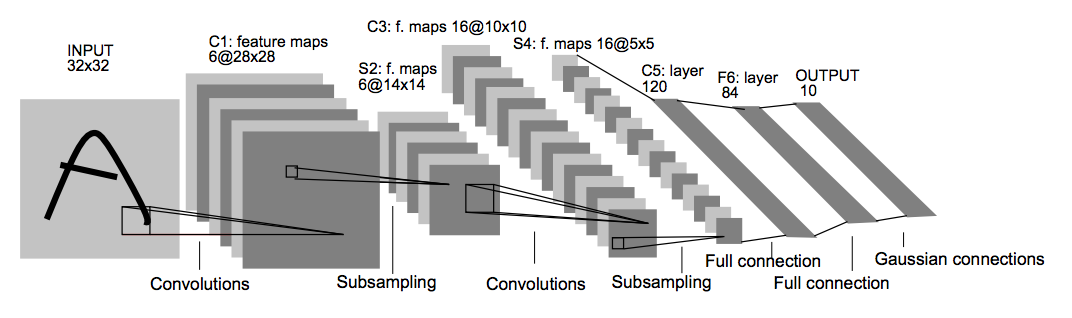

1.   Image Input: 28 (height) x 28 (width) x 1 (channel) 
2.   Convolution with 5x5 kernel + padding: 28x28x6 \[sigmoid activation\]
3.   Pooling with 2x2 average kernel: 14x14x6
4.   Convolution with 5x5 kernel (no padding): 10x10x16 \[sigmoid activation\]
5.   Pooling with 2x2 average kernel: 5x5x16
6.   Flatten
7.   Dense: 120 fully connected neurons \[sigmoid activation\]
8.   Dense: 84 fully connected neurons \[sigmoid activation\]
9.   Dense: 10 fully connected neurons \[softmax activation\]
10.  Output: 1 out of 10 classes

In [57]:
class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layer

        self.conv_1 = layers.Conv2D(filters=6, kernel_size=(5, 5), padding="same",
                                    activation='sigmoid', input_shape=(32, 32, 3))
        
        # Maxpooling layer
        
        self.pool_1 = layers.MaxPooling2D()
        
        # NEXT LAYERS

        self.conv_2 = layers.Conv2D(filters=16, kernel_size=(5, 5), padding="same",
                                    activation='sigmoid')
        self.pool_2 = layers.MaxPooling2D()

        # End Layers

        self.flat = layers.Flatten()

        self.fc1 = layers.Dense(units=120, activation='sigmoid')
        self.fc2 = layers.Dense(units=84, activation='sigmoid')
        
        # LAST LAYER - TODO
        self.fc3 = layers.Dense(units=10, activation = 'softmax')
    
    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.pool_1(y)
        y = self.conv_2(y)
        y = self.pool_2(y)
        y = self.flat(y)
        
        
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        return y

In [58]:
net = Net()
# Build the model
net.build([None, 32, 32, 3])

In [59]:
net.summary()

Model: "net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  456       
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           multiple                  2416      
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  123000

In [60]:
criterion =  tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.5, beta_2=0.99)

## Training

Custom Training loop

In [ ]:
from tqdm import tqdm

loss_history = [] 

for epoch in range(20): 
    running_loss = 0.0
    # We enumerate over the dataset, but call tqdm over that enumeration to get 
    # a pretty loading bar
    pbar = tqdm(enumerate(dataloader))
    for i, data in pbar:
        inputs, labels = data[0], data[1]
        # Enter the gradient recording phase
        with tf.GradientTape() as tape:
            outputs = net(inputs)
            loss = criterion(labels, outputs)
        gradients = tape.gradient(loss, net.trainable_variables)
        # Apply gradients
        optimizer.apply_gradients(zip(gradients, net.trainable_variables))
        loss_history.append(loss)

        running_loss += loss.numpy()
        if i % 10000 == 9999:    # print every 10000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10000))
            running_loss = 0.0

        pbar.set_postfix({'loss': loss.numpy()})
        
print('Finished Training')

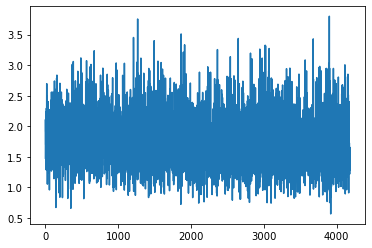

In [26]:
plt.plot(range(len(loss_history)), loss_history)

In [61]:
net = Net()
# Build the model
net.build([None, 32, 32, 3])

Alternatively (when possible) you can use the fit() function from Tensorflow

In [86]:
net.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

history = net.fit(dataloader, batch_size=32, epochs=15, validation_data=test_dataloader)

Epoch 1/15
2500/2500 [==============================] - 14s 5ms/step - loss: 0.9517 - accuracy: 0.6568 - val_loss: 0.8677 - val_accuracy: 0.6919
Epoch 2/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.8896 - accuracy: 0.6741 - val_loss: 0.7955 - val_accuracy: 0.7185
Epoch 3/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.8323 - accuracy: 0.6971 - val_loss: 0.7267 - val_accuracy: 0.7437
Epoch 4/15
2500/2500 [==============================] - 14s 6ms/step - loss: 0.7802 - accuracy: 0.7212 - val_loss: 0.6990 - val_accuracy: 0.7518
Epoch 5/15
2500/2500 [==============================] - 14s 5ms/step - loss: 0.7176 - accuracy: 0.7465 - val_loss: 0.6304 - val_accuracy: 0.7822
Epoch 6/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.6592 - accuracy: 0.7666 - val_loss: 0.5527 - val_accuracy: 0.8104
Epoch 7/15
2500/2500 [==============================] - 15s 6ms/step - loss: 0.5965 - accuracy: 0.7897 - val_loss: 0.5213 - val_ac

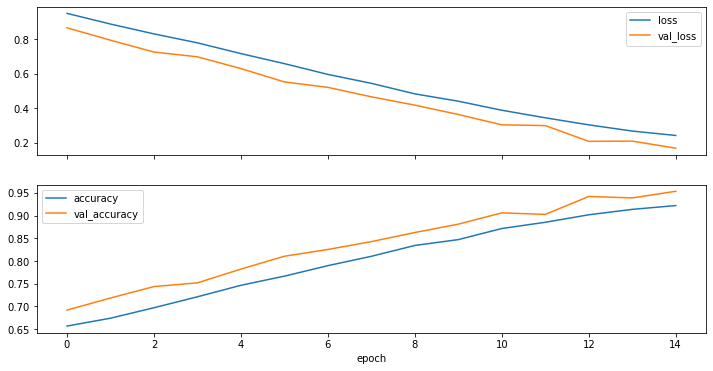

In [87]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
history_df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
history_df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

## Results

In [88]:
for i, data in enumerate(test_dataloader):
    inputs, labels = data[0], np.argmax(data[1], axis=-1)

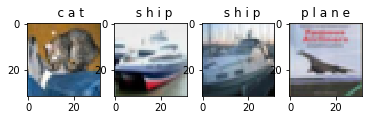

In [90]:
data = test_dataloader.__getitem__(0)
for i in range(4):
    plt.subplot(1, 4, i+1)
    inputs, labels = data[0], np.argmax(data[1], axis=-1)
    plt.imshow(inputs[i])
    plt.title(' '.join('%5s' % classes[tf.squeeze(labels[i])]))


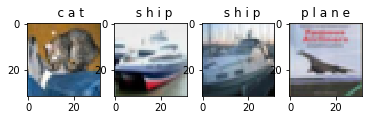

In [91]:
inputs, labels = data[0], np.argmax(data[1], axis=-1)
predicted_labels = net(inputs)
predicted_labels = np.argmax(predicted_labels, axis=-1)

for i in range(4):
    plt.subplot(1, 4, i+1)
    inputs, _ = data[0], np.argmax(data[1], axis=-1)
    plt.imshow(inputs[i])
    plt.title(' '.join('%5s' % classes[tf.squeeze(predicted_labels[i])]))

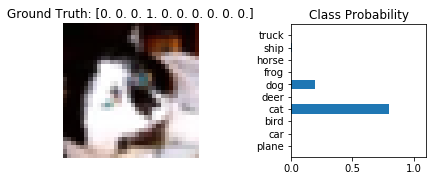

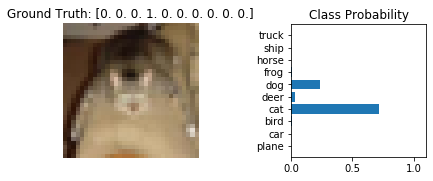

In [92]:
import random
import matplotlib.patches as patches
import tensorflow as tf

def test_model(x_test, y_test, model):
    n =  random.randint(0, x_test.shape[0])
    x = np.expand_dims(x_test[n], 0)
    y_pred=model(x)


    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.set_title('Ground Truth: {}'.format(y_test[n]))
    ax1.imshow(x_test[n], "Greys")
    ax1.axis('off')
    ax2.barh(np.arange(10), tf.squeeze(y_pred))
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

test_model(x_test, y_test, net)
test_model(x_test, y_test, net)

In [93]:
correct = 0
total = 0

for data in test_dataloader:
    images, labels = data
    inputs, labels = data[0], np.argmax(data[1], axis=-1)

    outputs = net(inputs)
    predicted = np.argmax(outputs, axis=-1)
    total += labels.shape[0]
    ########################
    #Your code Here
    correct += (predicted == labels).sum()
    ########################

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


In [94]:
confusion = np.zeros((10,10)).astype(int)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in test_dataloader:
    images, labels = data
    inputs, labels = data[0], np.argmax(data[1], axis=-1)

    outputs = net(inputs)
    predicted = np.argmax(outputs, axis=-1)
    correct = (predicted == labels)

    for i in range(4):
        label = labels[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        confusion[labels[i], predicted[i]] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 97 %
Accuracy of   car : 98 %
Accuracy of  bird : 87 %
Accuracy of   cat : 88 %
Accuracy of  deer : 92 %
Accuracy of   dog : 97 %
Accuracy of  frog : 96 %
Accuracy of horse : 98 %
Accuracy of  ship : 98 %
Accuracy of truck : 97 %


### Confusion matrix

The lines indicate the true label, the columns indicate the predicted label.

In [95]:
!pip install -U install seaborn

Requirement already up-to-date: install in /home/fbhavsar/.local/lib/python3.8/site-packages (1.3.5)
Requirement already up-to-date: seaborn in /home/fbhavsar/.local/lib/python3.8/site-packages (0.13.2)


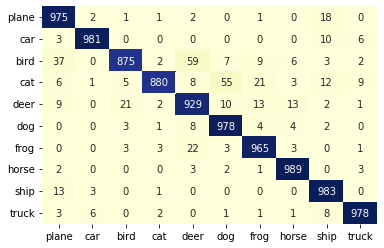

In [96]:
import seaborn as sns
sns.heatmap(confusion,cmap="YlGnBu", annot=True, fmt=".4g",cbar=False,xticklabels=classes, yticklabels=classes)

## Display the weights

### Weights of the first layer

We can access a layer of a model in keras using the following syntax :

model.layers[index_of_layer]

This return a Layer object, on which we can call get_weights() to return a tuple (kernel, bias)

In [97]:
def show_conv_kernel(weights):
    for i in range(weights.shape[2]):
        plt.figure(figsize=(50, 120))
        kernel_shape = weights.shape[-1]
        for j in range(kernel_shape):
          plt.subplot(1, kernel_shape, j+1)
          plt.axis('off')
          plt.imshow(weights[:, :, i, j], cmap='gray_r')
        plt.show()

In [98]:
net.layers

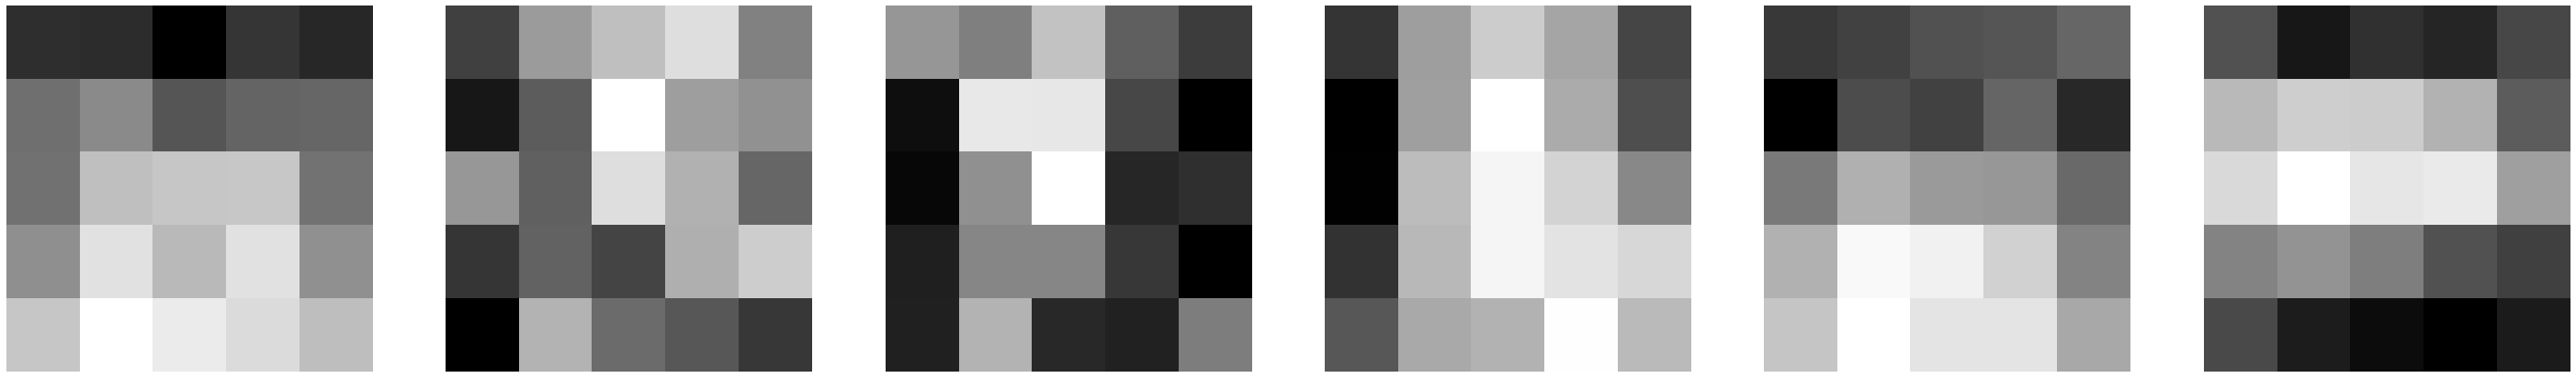

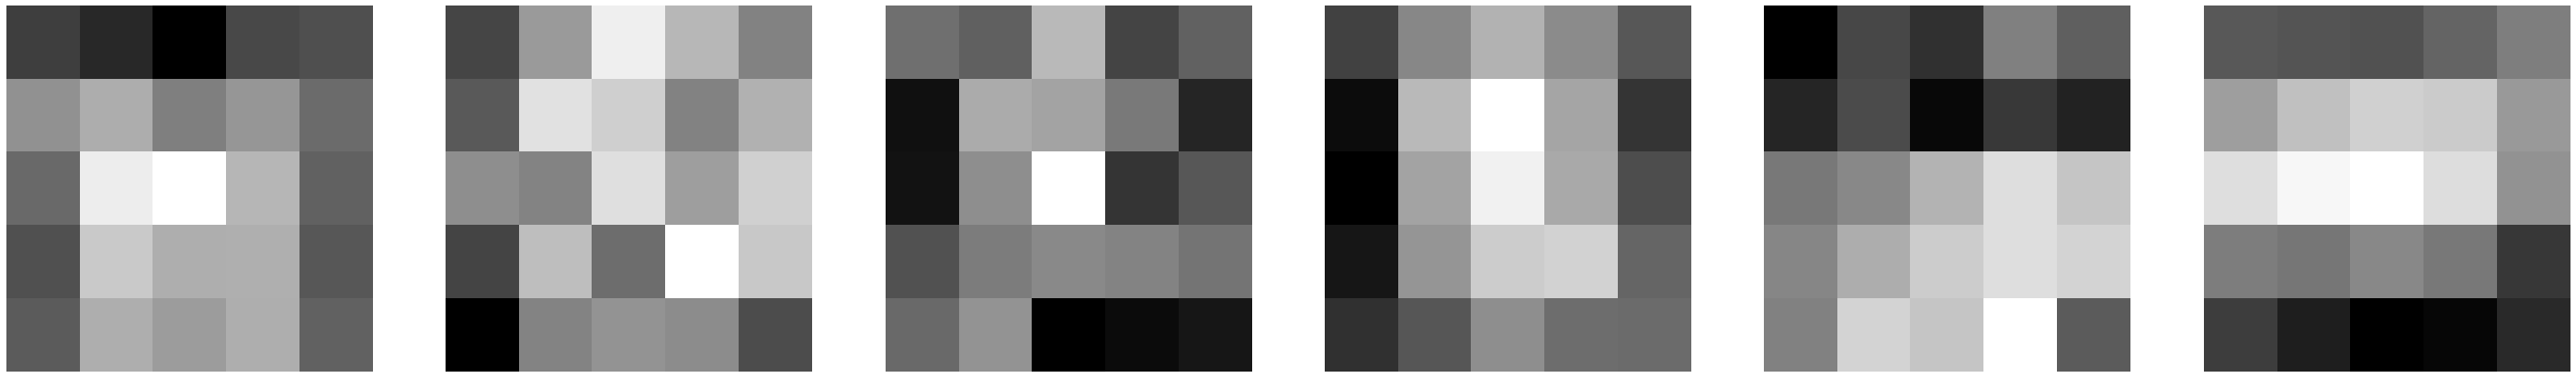

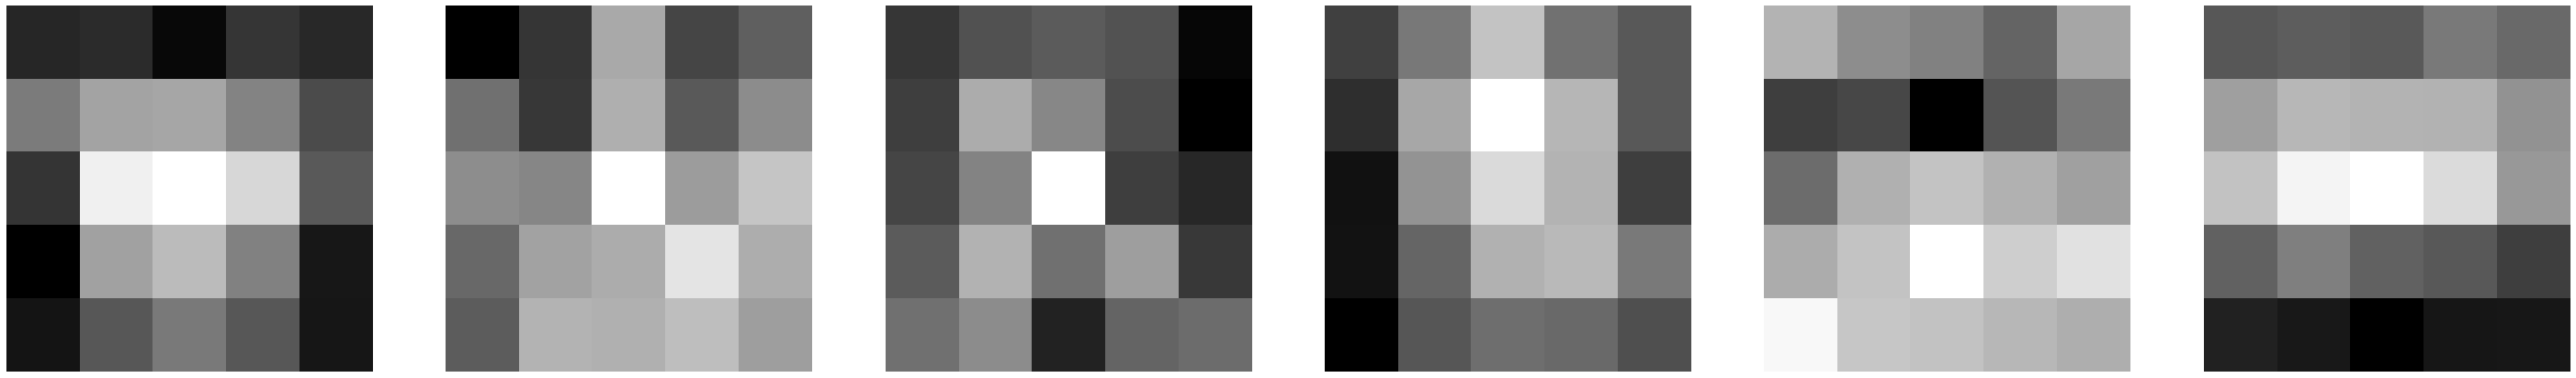

In [99]:
# Access the First layer weight
weights, biases = net.layers[0].get_weights()
show_conv_kernel(weights)

### Weights of the second layer

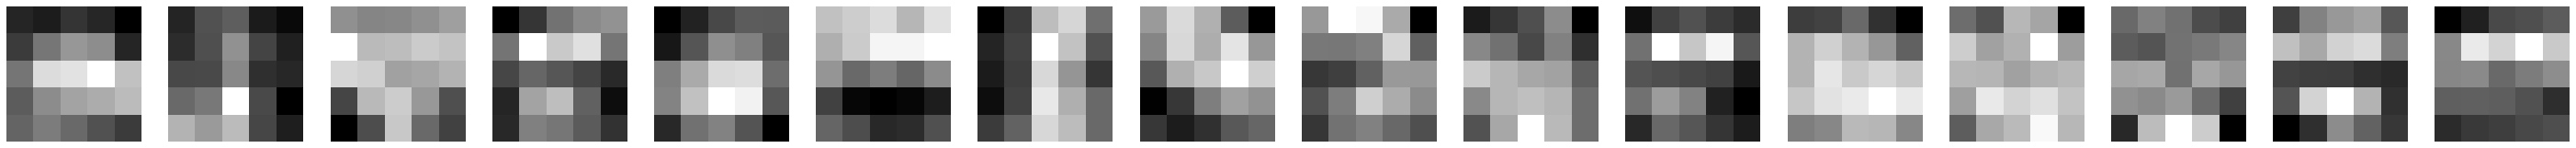

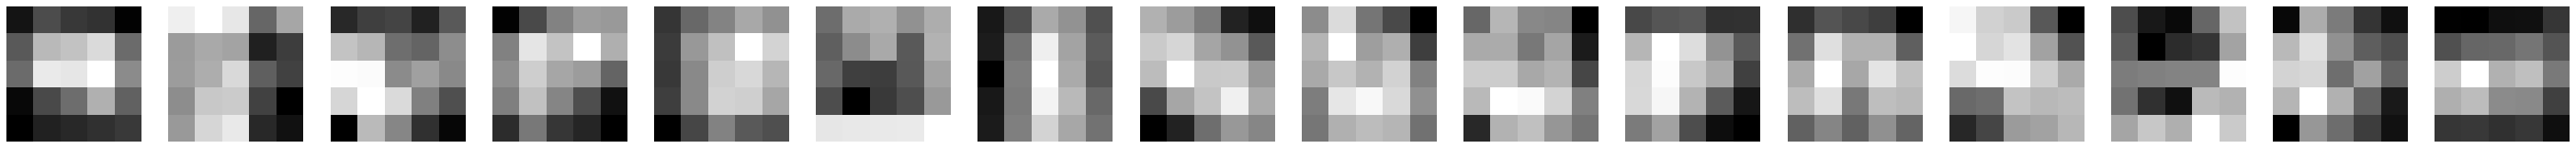

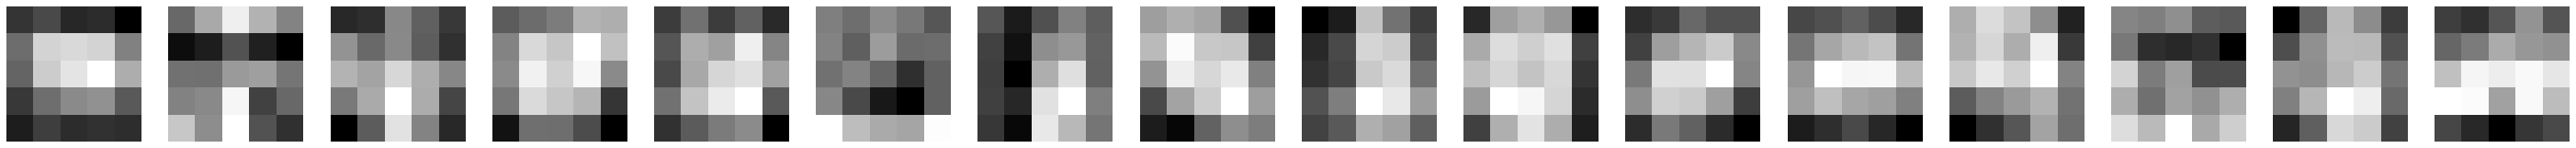

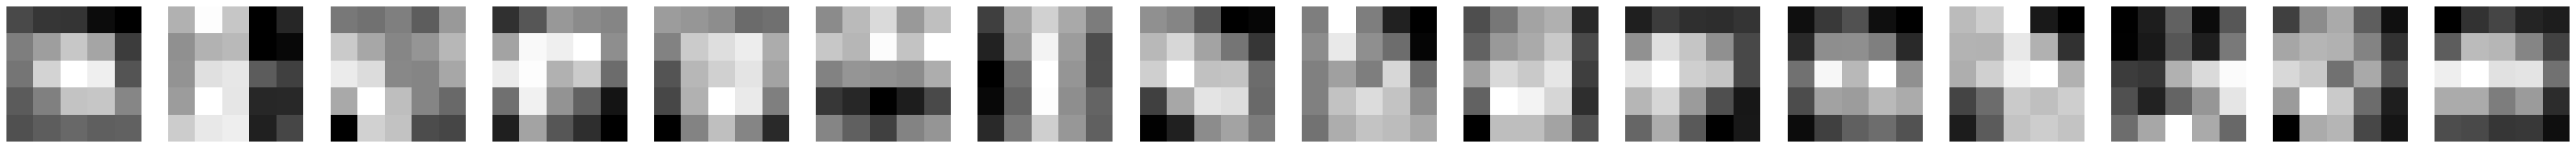

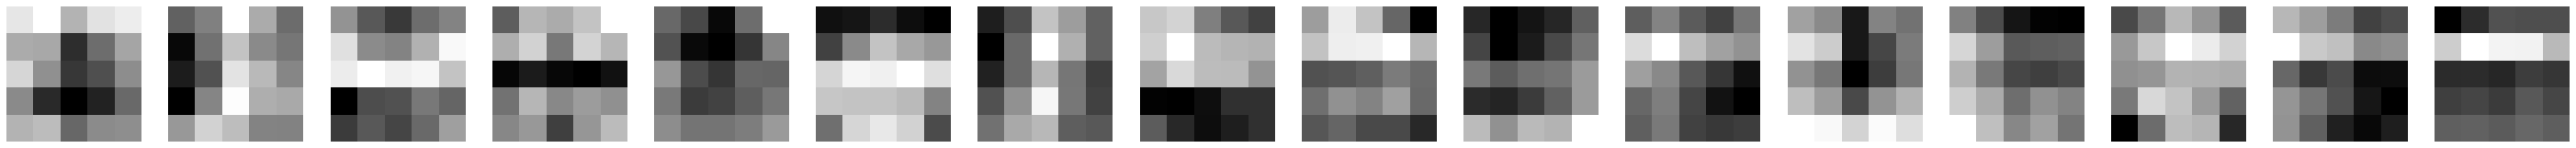

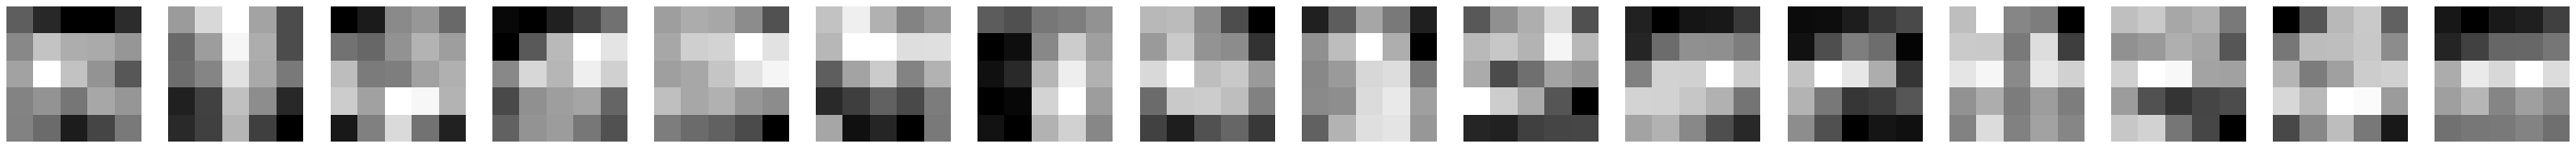

In [100]:
# Access the Second layer weights
weights, biases = net.layers[2].get_weights()
show_conv_kernel(weights)

## Display the feature maps after each layer

We recall the forward function which show the different layer

```
    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.pool(y)
        y = self.conv_2(y)
        y = self.flat(y)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        return y
```

Since we can access the layer separately, we can use separately. This allow us to check the outputs at each levels. Let's test that.


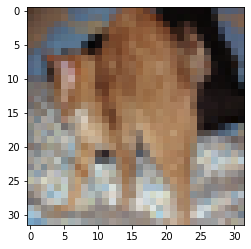

In [101]:
inputs, labels = data[0], np.argmax(data[1], axis=-1)
predicted_labels = net(inputs)
predicted_labels = np.argmax(predicted_labels, axis=-1)

img = inputs[0]
plt.imshow(img)
# Don't mind that img_extended, it's add a single dimension (batche dim) to our image
img_extended = tf.expand_dims(img, axis=0)

In [102]:
classes[predicted_labels[0]]

'cat'

In [103]:
def show_activation_maps(activation_maps):
    maps = tf.squeeze(activation_maps)
    nb_channels = maps.shape[-1]
    plt.figure(figsize=(70, 200))
    for channel in range(nb_channels):
          plt.subplot(1, nb_channels, channel+1)
          plt.imshow(maps[:, :, channel], cmap='gray_r')
    plt.show()

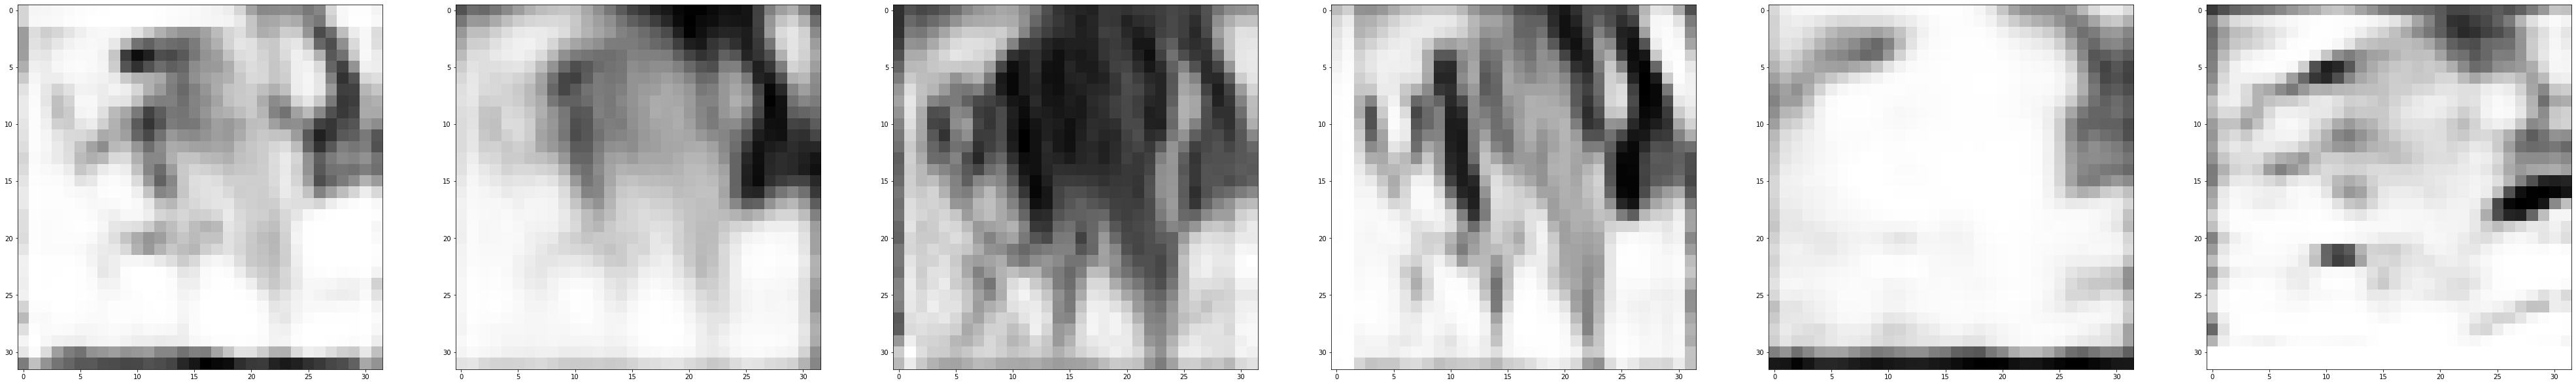

In [104]:
# Call the first layer on the image
activations_fst_layer = net.layers[0](img_extended)
show_activation_maps(activations_fst_layer)

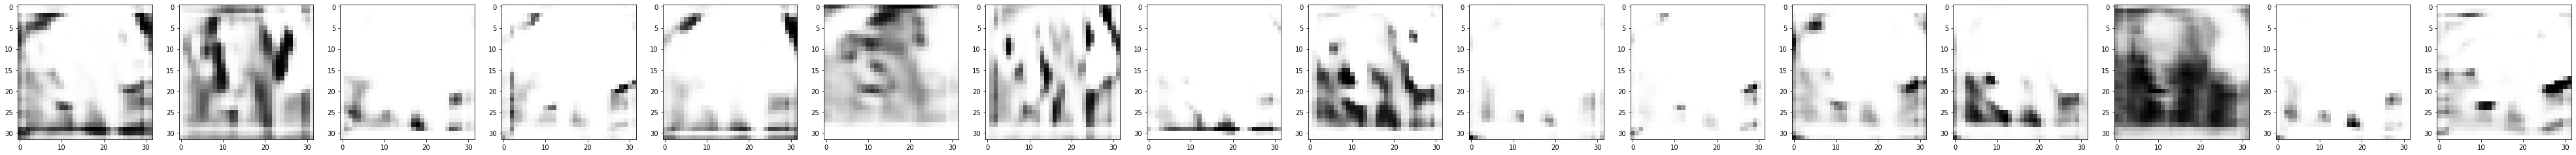

In [105]:
# Call the second layer
activations_snd_layer = net.layers[2](activations_fst_layer)
show_activation_maps(activations_snd_layer)